In [55]:
import os, sys, email
import pandas as pd
import numpy as np
import re

import pyvis
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(2018)
import nltk
nltk.download('wordnet')

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

#from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

import spacy
spacy.cli.download("en_core_web_sm")

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/purvitiwari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
emails_df = pd.read_csv("emails.csv")
len(emails_df)

517401

In [3]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


In [4]:
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [5]:
print(emails_df['message'][450000])

Message-ID: <21899142.1075862394894.JavaMail.evans@thyme>
Date: Mon, 19 Nov 2001 13:34:59 -0800 (PST)
From: no.address@enron.com
Subject: Holiday Party - Canceled
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Ken Lay- Chairman of the Board & CEO@ENRON
X-To: All Enron Houston@ENRON <??SAll Enron Houston@ENRON>
X-cc: 
X-bcc: 
X-Folder: \TSTAAB (Non-Privileged)\Staab, Theresa\Inbox
X-Origin: Staab-T
X-FileName: TSTAAB (Non-Privileged).pst


I know that this is a difficult time for all of us.  With everything going on inside the company as well as in the world around us, we have been carefully considering whether a holiday celebration is appropriate this year.  To be honest, employee feedback has been mixed.  Many viewed the holiday party as a unique opportunity for us to come together as Enron employees to share the spirit of the season.  Others felt a holiday party would be improper given the company's current circumstances.

After w

In [6]:
#Getting the contents of email
def get_content_of_email(body):
    parts = []
    for part in body.walk():
        if part.get_content_type() == 'text/plain': 
            parts.append(part.get_payload())
    return ''.join(parts)

In [7]:
#Getting email address
def get_email_address(line): 
    if line:
        address = line.split(',')
        address = frozenset(map(lambda x : x.strip(), address))
    else:
        address = None
    return address

In [8]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True) 

# Get all fields from the email objects
fields = messages[0].keys()
for field in fields:
    emails_df[field] = [doc[field] for doc in messages]
    
#getting content from emails
emails_df['content'] = list(map(get_content_of_email, messages))

# Splitting email address
emails_df['From'] = emails_df['From'].map(get_email_address)
emails_df['To'] = emails_df['To'].map(get_email_address)

#getting username
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

In [9]:
def remove_forwarded_by(text):
    condition = "[- ]*Forwarded by[\S\s]*Subject:[\S\t ]*"
    return re.sub(condition, "", text).strip()

In [10]:
# Getting originial emails
emails_df["content"] = emails_df.content.map(remove_forwarded_by)
emails_df = emails_df[emails_df["content"].str.contains("-----Original Message-----")]

In [11]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69514 entries, 942 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   file                       69514 non-null  object
 1   Message-ID                 69514 non-null  object
 2   Date                       69514 non-null  object
 3   From                       69514 non-null  object
 4   To                         69062 non-null  object
 5   Subject                    69514 non-null  object
 6   Mime-Version               69514 non-null  object
 7   Content-Type               69514 non-null  object
 8   Content-Transfer-Encoding  69514 non-null  object
 9   X-From                     69514 non-null  object
 10  X-To                       69514 non-null  object
 11  X-cc                       69514 non-null  object
 12  X-bcc                      69514 non-null  object
 13  X-Folder                   69514 non-null  object
 14  X-O

In [12]:
emails_df = emails_df.set_index('Message-ID').drop(['file','Mime-Version','Content-Type', 
                                                    'Content-Transfer-Encoding','Subject', 'X-FileName', 'X-Folder',
                                                    'X-Origin', 'X-FileName', 'X-cc', 'X-bcc', ], axis=1)
emails_df['Date'] = pd.to_datetime(emails_df['Date'], utc = True)
emails_df['Date'] = emails_df['Date'].dt.date

In [13]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69514 entries, <2194589.1075855666394.JavaMail.evans@thyme> to <28618979.1075842030037.JavaMail.evans@thyme>
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     69514 non-null  object
 1   From     69514 non-null  object
 2   To       69062 non-null  object
 3   X-From   69514 non-null  object
 4   X-To     69514 non-null  object
 5   content  69514 non-null  object
 6   user     69514 non-null  object
dtypes: object(7)
memory usage: 4.2+ MB


In [14]:
emails_df.user.nunique()

149

In [15]:
emails_df.to_csv("emails_cleaned.csv")

In [16]:
emails_df['From'].nunique()

5221

In [17]:
emails_df['To'].nunique()

15443

In [18]:
emails_df.head()

,Date,From,To,X-From,X-To,content,user
Message-ID,,,,,,,
<2194589.1075855666394.JavaMail.evans@thyme>,2000-12-11,(jsmith@austintx.com),(phillip.k.allen@enron.com),"""Jeff Smith"" <jsmith@austintx.com>",<Phillip.K.Allen@enron.com>,I WILL TALK TO LUTZ ABOUT HIS SHARE OF THE LEG...,allen-p
<8914065.1075858632242.JavaMail.evans@thyme>,2001-10-18,(no.address@enron.com),None,Enron Global Technology@ENRON,All Enron Worldwide@ENRON <??SAll Enron Worldw...,"Earlier this week, Enron Global Technology ann...",allen-p
<6254563.1075858632387.JavaMail.evans@thyme>,2001-10-19,(bodyshop@enron.com),(bodyshop@enron.com),Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BODY...,Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Body...,"-----Original Message-----\nFrom: \tWright, Le...",allen-p
<3461377.1075858633882.JavaMail.evans@thyme>,2001-10-22,(w..cantrell@enron.com),"(l..nicolay@enron.com, frank.ermis@enron.com, ...","Cantrell, Rebecca W. </O=ENRON/OU=NA/CN=RECIPI...","Lawner, Leslie </O=ENRON/OU=NA/CN=RECIPIENTS/C...",Updated to include comments received as of Fri...,allen-p
<8996818.1075858633953.JavaMail.evans@thyme>,2001-10-22,(mike.grigsby@enron.com),"(matt.smith@enron.com, tori.kuykendall@enron.c...","Grigsby, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...","-----Original Message-----\nFrom: \tSheppard, ...",allen-p


In [19]:
emails_df = emails_df.reset_index(drop = True)

In [20]:
emails_df.head()

,Date,From,To,X-From,X-To,content,user
0,2000-12-11,(jsmith@austintx.com),(phillip.k.allen@enron.com),"""Jeff Smith"" <jsmith@austintx.com>",<Phillip.K.Allen@enron.com>,I WILL TALK TO LUTZ ABOUT HIS SHARE OF THE LEG...,allen-p
1,2001-10-18,(no.address@enron.com),None,Enron Global Technology@ENRON,All Enron Worldwide@ENRON <??SAll Enron Worldw...,"Earlier this week, Enron Global Technology ann...",allen-p
2,2001-10-19,(bodyshop@enron.com),(bodyshop@enron.com),Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BODY...,Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Body...,"-----Original Message-----\nFrom: \tWright, Le...",allen-p
3,2001-10-22,(w..cantrell@enron.com),"(l..nicolay@enron.com, frank.ermis@enron.com, ...","Cantrell, Rebecca W. </O=ENRON/OU=NA/CN=RECIPI...","Lawner, Leslie </O=ENRON/OU=NA/CN=RECIPIENTS/C...",Updated to include comments received as of Fri...,allen-p
4,2001-10-22,(mike.grigsby@enron.com),"(matt.smith@enron.com, tori.kuykendall@enron.c...","Grigsby, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...","-----Original Message-----\nFrom: \tSheppard, ...",allen-p


## who send most emails to whom

In [21]:
user = ['derrick-j', 'forney-j', 'lay-k', 'delainey-d', 'skilling-j']

In [22]:
emails_df = emails_df[emails_df['user'].isin(user)]

In [23]:
emails_df.head()

,Date,From,To,X-From,X-To,content,user
12740,2001-12-28,(shona.wilson@enron.com),"(sheri.thomas@enron.com, loretta.brooks@enron....","Wilson, Shona </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Abel, Chris </O=ENRON/OU=NA/CN=RECIPIENTS/CN=C...",The preliminary should be out by the end of th...,delainey-d
12741,2001-12-28,(tharsilla.broussard@enron.com),(w..delainey@enron.com),"Broussard, Tharsilla </O=ENRON/OU=NA/CN=RECIPI...","Delainey, David W. </O=ENRON/OU=NA/CN=RECIPIEN...",You're very welcome! You have a good new year...,delainey-d
12742,2001-12-27,(s..muller@enron.com),(w..delainey@enron.com),"Muller, Mark S. </O=ENRON/OU=NA/CN=RECIPIENTS/...","Delainey, David W. </O=ENRON/OU=NA/CN=RECIPIEN...",aren't you supposed to be skiing\n\n-----Origi...,delainey-d
12743,2001-12-23,(no.address@enron.com),"(jeffrey.mcmahon@enron.com, janet.dietrich@enr...","Miller, Don (Asset Mktg) </O=ENRON/OU=NA/CN=RE...","Dietrich, Janet </O=ENRON/OU=NA/CN=RECIPIENTS/...",I will track down more details this week. \n ...,delainey-d
12744,2002-01-10,(david.oxley@enron.com),"(kriste.sullivan@enron.com, exec.jones@enron.c...","Oxley, David </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Dietrich, Janet </O=ENRON/OU=NA/CN=RECIPIENTS/...",OK. We actually had here on NETCo list. I'll r...,delainey-d


In [24]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 12740 to 57258
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1717 non-null   object
 1   From     1717 non-null   object
 2   To       1670 non-null   object
 3   X-From   1717 non-null   object
 4   X-To     1717 non-null   object
 5   content  1717 non-null   object
 6   user     1717 non-null   object
dtypes: object(7)
memory usage: 107.3+ KB


### saving the cleaned data with person of interest as "data_poi"

In [25]:
emails_df.to_csv("data_poi.csv")

In [26]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 
                   'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 
                   'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [27]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

In [28]:
# Convert to list
data = emails_df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'preliminary', 'should', 'be', 'out', 'by', 'the', 'end', 'of', 'the', 'day', 'on', 'the', 'nd', 'of', 'january', 'not', 'the', 'st', 'as', 'noted', 'below', 'sorry', 'for', 'the', 'confusion', 'regards', 'original', 'message', 'from', 'wilson', 'shona', 'sent', 'friday', 'december', 'am', 'to', 'abel', 'chris', 'andrews', 'naveen', 'apollo', 'beth', 'beck', 'sally', 'belden', 'tim', 'bowen', 'jr', 'raymond', 'bradford', 'william', 'brooks', 'loretta', 'buy', 'rick', 'cast', 'leman', 'kent', 'causey', 'richard', 'cockrell', 'rainier', 'colwell', 'wes', 'curry', 'wanda', 'day', 'misti', 'delainey', 'david', 'dietrich', 'janet', 'fallon', 'jim', 'frevert', 'ma', 'rk', 'gold', 'joe', 'gossett', 'jeffrey', 'haedicke', 'mark', 'hagelmann', 'bjorn', 'ha', 'll', 'todd', 'hanson', 'kristen', 'hardy', 'trey', 'hayden', 'frank', 'helton', 'susan', 'hickerson', 'gary', 'hillis', 'kimberly', 'hodges', 'georgeanne', 'kaminski', 'vince', 'kass', 'michael', 'kathol', 'sherri', 'killen', 'fai

In [29]:
len(data_words)

1717

In [31]:
def process_words(texts, stop_words=stop_words, 
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) 
              if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) 
                  if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [32]:
data_ready

[['preliminary',
  'end',
  'day',
  'note',
  'sorry',
  'confusion',
  'regard',
  'original',
  'message',
  'shona',
  'send',
  'buy',
  'cast',
  'curry',
  'day',
  'todd',
  'hanson',
  'kristen',
  'hardy',
  'trey',
  'hodge',
  'te',
  'tammie',
  'tammy',
  'white',
  'stacey',
  'white',
  'susie',
  'fran',
  'carol',
  'reeve',
  'dpr',
  'reporting',
  'plan',
  'report',
  'consolidated',
  'dpr',
  'trading',
  'date',
  'dpr',
  'trading',
  'date',
  'goal',
  'publish',
  'pre',
  'liminary',
  'form',
  'end',
  'day',
  'call',
  'question',
  'comment',
  'report',
  'sche',
  'happy',
  'new',
  'year',
  'regard',
  'global',
  'risk',
  'operation'],
 ['welcome',
  'new',
  'year',
  'original',
  'message',
  'delainey',
  'send',
  'pm',
  'davy',
  'neil',
  'urgent',
  'request',
  'information',
  'much',
  'guy',
  'much',
  'appreciate',
  'new',
  'year',
  'original',
  'message',
  'davy',
  'neil',
  'send',
  'request',
  'information',
  'well',


# Build the Word Embedding Model

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
print(id2word)

Dictionary(11276 unique tokens: ['buy', 'call', 'carol', 'cast', 'comment']...)


In [34]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (10, 3), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1)]]


In [35]:
id2word[0]

'buy'

In [36]:
from gensim.models import Word2Vec
from nltk.corpus import gutenberg
from multiprocessing import Pool

In [37]:
dictionary = corpora.Dictionary(data_ready)
text_term_matrix = [dictionary.doc2bow(text) for text in data_ready]

In [38]:
len(data_ready)

1717

In [39]:
for i in range(len(data_ready)):
    data_ready[i] = [word.lower() for word in data_ready[i] if re.match('^[a-zA-Z]+', word)]

In [40]:
model_enron = Word2Vec(sentences = data_ready, sg = 1, window = 3, 
                 min_count = 1, workers = Pool()._processes)

In [41]:
model_enron.init_sims(replace = True)

In [42]:
model_enron.save('word2vec_model_enron_final')

In [43]:
model_enron = Word2Vec.load('word2vec_model_enron_final')

In [44]:
model_enron.wv.most_similar(['bankruptcy'])

[('insurance', 0.973651111125946),
 ('reject', 0.9732587337493896),
 ('fulfill', 0.971235990524292),
 ('prevent', 0.9697921872138977),
 ('sanjeev', 0.9687309265136719),
 ('escrow', 0.9686329960823059),
 ('pzu', 0.9682369232177734),
 ('insufficient', 0.9681059122085571),
 ('usd', 0.9676991105079651),
 ('deposit', 0.9669208526611328)]

In [45]:
model_enron.wv.similarity('bankruptcy', 'business')

0.47774357

In [46]:
keys = ['crime', 'gas', 'transaction', 'meeting', 'mother', 'life', 'schedule', 'financial', 'energy',
       'country', 'bankruptcy']

In [47]:
from sklearn.manifold import TSNE
import numpy as np

warnings.filterwarnings("ignore")

In [48]:
words=list(model_enron.wv.key_to_index)

In [49]:
words

['message',
 'send',
 'original',
 'com',
 'mail',
 'time',
 'http',
 'page',
 'bna',
 'call',
 'work',
 'ip',
 'information',
 'pub',
 'year',
 'nsf',
 'company',
 'email',
 'receive',
 'meeting',
 'den',
 'regard',
 'let',
 'follow',
 'report',
 'issue',
 'intend',
 'change',
 'last',
 'market',
 'group',
 'service',
 'well',
 'business',
 'day',
 'new',
 'look',
 'week',
 'give',
 'review',
 'contact',
 'date',
 'recipient',
 'ercot',
 'schedule',
 'ask',
 'meet',
 'request',
 'attach',
 'file',
 'include',
 'plan',
 'power',
 'provide',
 'name',
 'question',
 'help',
 'forward',
 'law',
 'next',
 'lie',
 'energy',
 'contract',
 'copy',
 'today',
 'employee',
 'status',
 'state',
 'pay',
 'gas',
 'way',
 'high',
 'confidential',
 'expense',
 'support',
 'price',
 'payment',
 'office',
 'leave',
 'number',
 'pm',
 'find',
 'address',
 'amount',
 'skille',
 'much',
 'due',
 'system',
 'great',
 'opportunity',
 'mark',
 'document',
 'discuss',
 'list',
 'first',
 'hope',
 'contain',
 '

In [50]:
keys = [ 'bankrupt',  'fail', 'disclose', 'chairman', 'appeal'] 

In [51]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model_enron.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model_enron.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [52]:
from sklearn.manifold import TSNE
import numpy as np

warnings.filterwarnings("ignore")

In [53]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

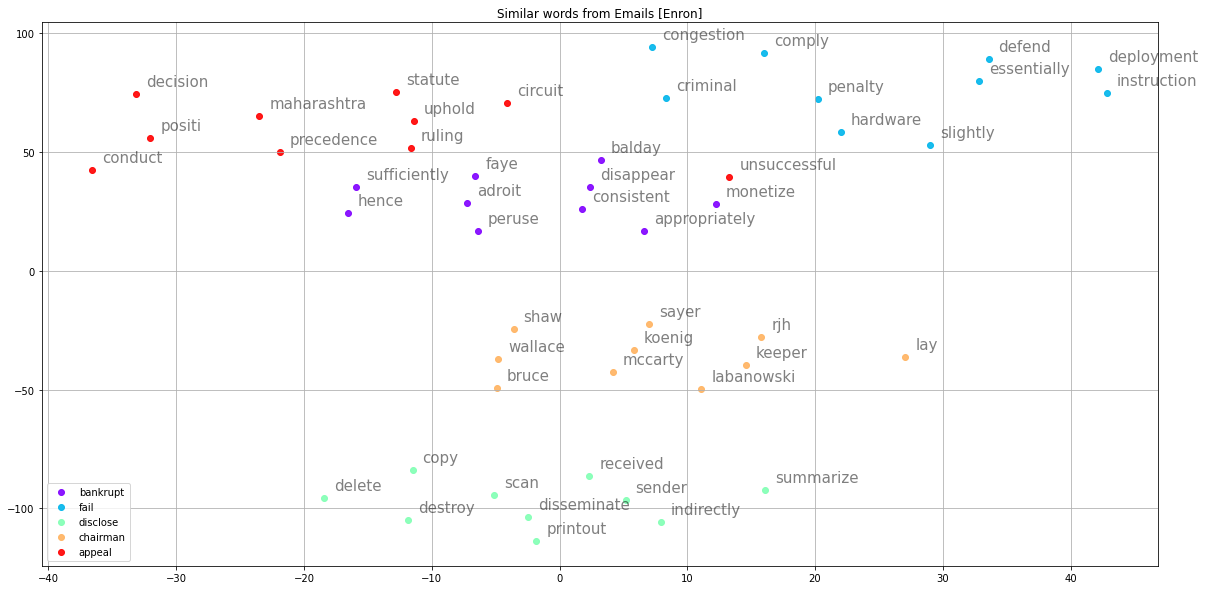

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

warnings.filterwarnings("ignore")

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(20, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(10, 5),
                         textcoords='offset points', ha='left', va='bottom', size=15)
    plt.legend(loc=3)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Emails [Enron]', keys, embeddings_en_2d, word_clusters, 0.9,
                        'similar_words.png')

# Build the Topic Model 

In [56]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [57]:
print( lda_model.print_topics())

[(0, '0.012*"business" + 0.012*"company" + 0.011*"market" + 0.009*"open" + 0.007*"sell" + 0.007*"support" + 0.007*"energy" + 0.006*"value" + 0.006*"technology" + 0.006*"price"'), (1, '0.068*"beta" + 0.043*"homecoming" + 0.040*"com" + 0.026*"tent" + 0.024*"consider" + 0.023*"reunion" + 0.022*"crowd" + 0.022*"incredible" + 0.017*"term" + 0.016*"class"'), (2, '0.021*"send" + 0.020*"message" + 0.017*"time" + 0.017*"year" + 0.017*"original" + 0.011*"jeff" + 0.011*"regard" + 0.010*"call" + 0.010*"schedule" + 0.010*"let"'), (3, '0.066*"message" + 0.026*"information" + 0.019*"dinner" + 0.018*"error" + 0.016*"jerry" + 0.015*"intend" + 0.014*"yahoo" + 0.013*"email" + 0.013*"send" + 0.013*"copy"')]


In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [59]:
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis
#pyLDAvis.show(vis)

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.231713 -0.134389       1        1  43.076128
0     -0.135522 -0.228796       2        1  30.039846
3      0.161691  0.223541       3        1  17.171709
1     -0.257882  0.139644       4        1   9.712318, topic_info=              Term         Freq        Total Category  logprob  loglift
22         message  4175.000000  4175.000000  Default  30.0000  30.0000
8528          beta  1392.000000  1392.000000  Default  29.0000  29.0000
10343   homecoming   885.000000   885.000000  Default  28.0000  28.0000
563            com  1123.000000  1123.000000  Default  27.0000  27.0000
85     information  1064.000000  1064.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1117        search   137.038649   169.058010   Topic4  -5.0068   2.1218
406       consider   489.185230   843.548306   Topic4  -3.7343   1.7869
438           term   356.665605   653.127320   Topic4  -4.0503   1.7268
1096       sponsor   128.302878   166.026512   Topic4  -5.0727   2.0740
454           free   115.535303   425.184215   Topic4  -5.1775   1.0288

[215 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
556        2  0.004319  address
556        3  0.997743  address
271        1  0.257300   advise
271        3  0.741493   advise
2240       1  0.982836      ago
...      ...       ...      ...
50         1  0.884681     year
50         2  0.115519     year
10648      1  0.008845   yssfaa
10648      2  0.008845   yssfaa
10648      4  0.981799   yssfaa

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [60]:
coherence = []
for k in range(2,10):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus,
                   id2word=id2word,
                   num_topics=k, 
                   random_state=100,
                   update_every=1,
                   chunksize=10,
                   passes=10,
                   alpha='symmetric',
                   iterations=100,
                   per_word_topics=True)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=data_ready,\
         dictionary=id2word, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))
    
    lda_model1 = gensim.models.ldamodel.LdaModel

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9


In [61]:
coherence

[(2, 0.4531458554877764),
 (3, 0.5948386886659819),
 (4, 0.6617813758106227),
 (5, 0.5340132164123117),
 (6, 0.4302751077242539),
 (7, 0.4360939563864749),
 (8, 0.3856064994657924),
 (9, 0.3903861332161911)]

In [62]:
from gensim.models.coherencemodel import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.369863707286553

Coherence Score:  0.6617813758106227


In [63]:
pyLDAvis.save_html(vis, 'lda_enron_final.html')

## Coherence value is highest for number of topics = 4

In [64]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                    ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

   
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [65]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, 
                                                  texts=data_ready)

In [66]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 
                             'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6350,"send, message, time, year, original, jeff, reg...","[preliminary, end, day, note, sorry, confusion..."
1,1,2.0,0.6577,"send, message, time, year, original, jeff, reg...","[welcome, new, year, original, message, delain..."
2,2,2.0,0.6211,"send, message, time, year, original, jeff, reg...","[suppose, ski, original, message, delainey, se..."
3,3,2.0,0.6707,"send, message, time, year, original, jeff, reg...","[track, detail, week, janet, read, west, coast..."
4,4,2.0,0.5014,"send, message, time, year, original, jeff, reg...","[actually, netco, list, ill, remove, original,..."
5,5,2.0,0.9354,"send, message, time, year, original, jeff, reg...","[thing, thought, team, original, message, dela..."
6,6,2.0,0.5963,"send, message, time, year, original, jeff, reg...","[let, status, alan, payment, call, left, messa..."
7,7,0.0,0.4555,"business, company, market, open, sell, support...","[original, message, tori, behalf, lie, send, d..."
8,8,2.0,0.5108,"send, message, time, year, original, jeff, reg...","[gather, much, information, possible, exposure..."
9,9,0.0,0.7207,"business, company, market, open, sell, support...","[forward, yet, require, action, original, mess..."


In [67]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

In [68]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Importance of Topic Keywords

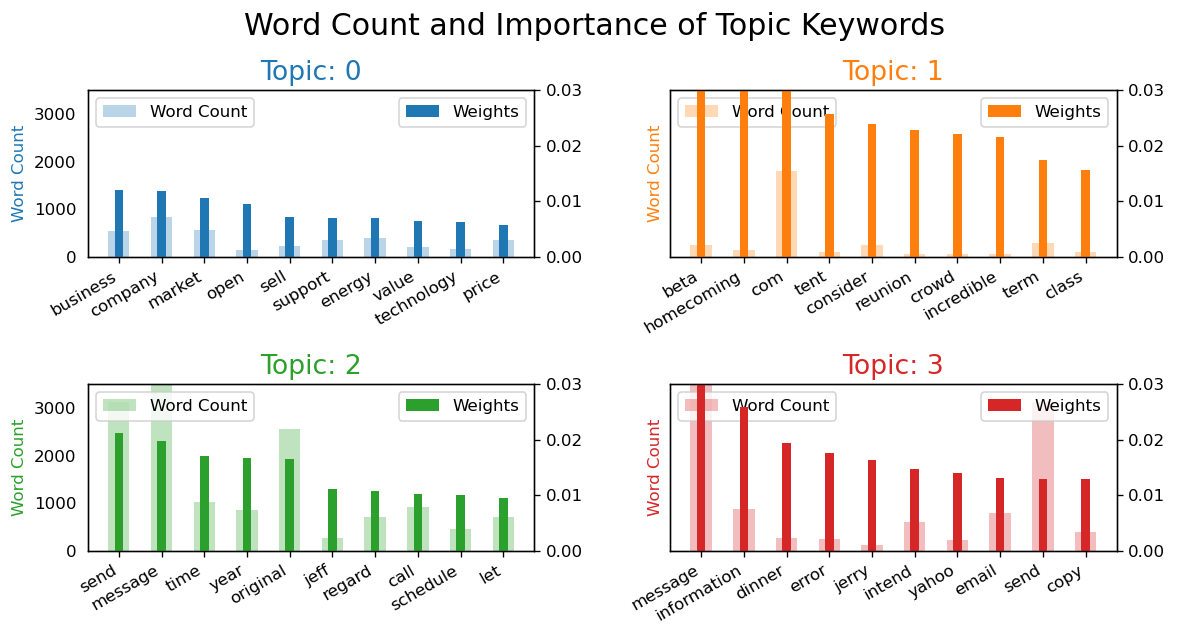

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), sharey=True, dpi=120)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05)    
plt.show()

# Sentence Topic Coloring

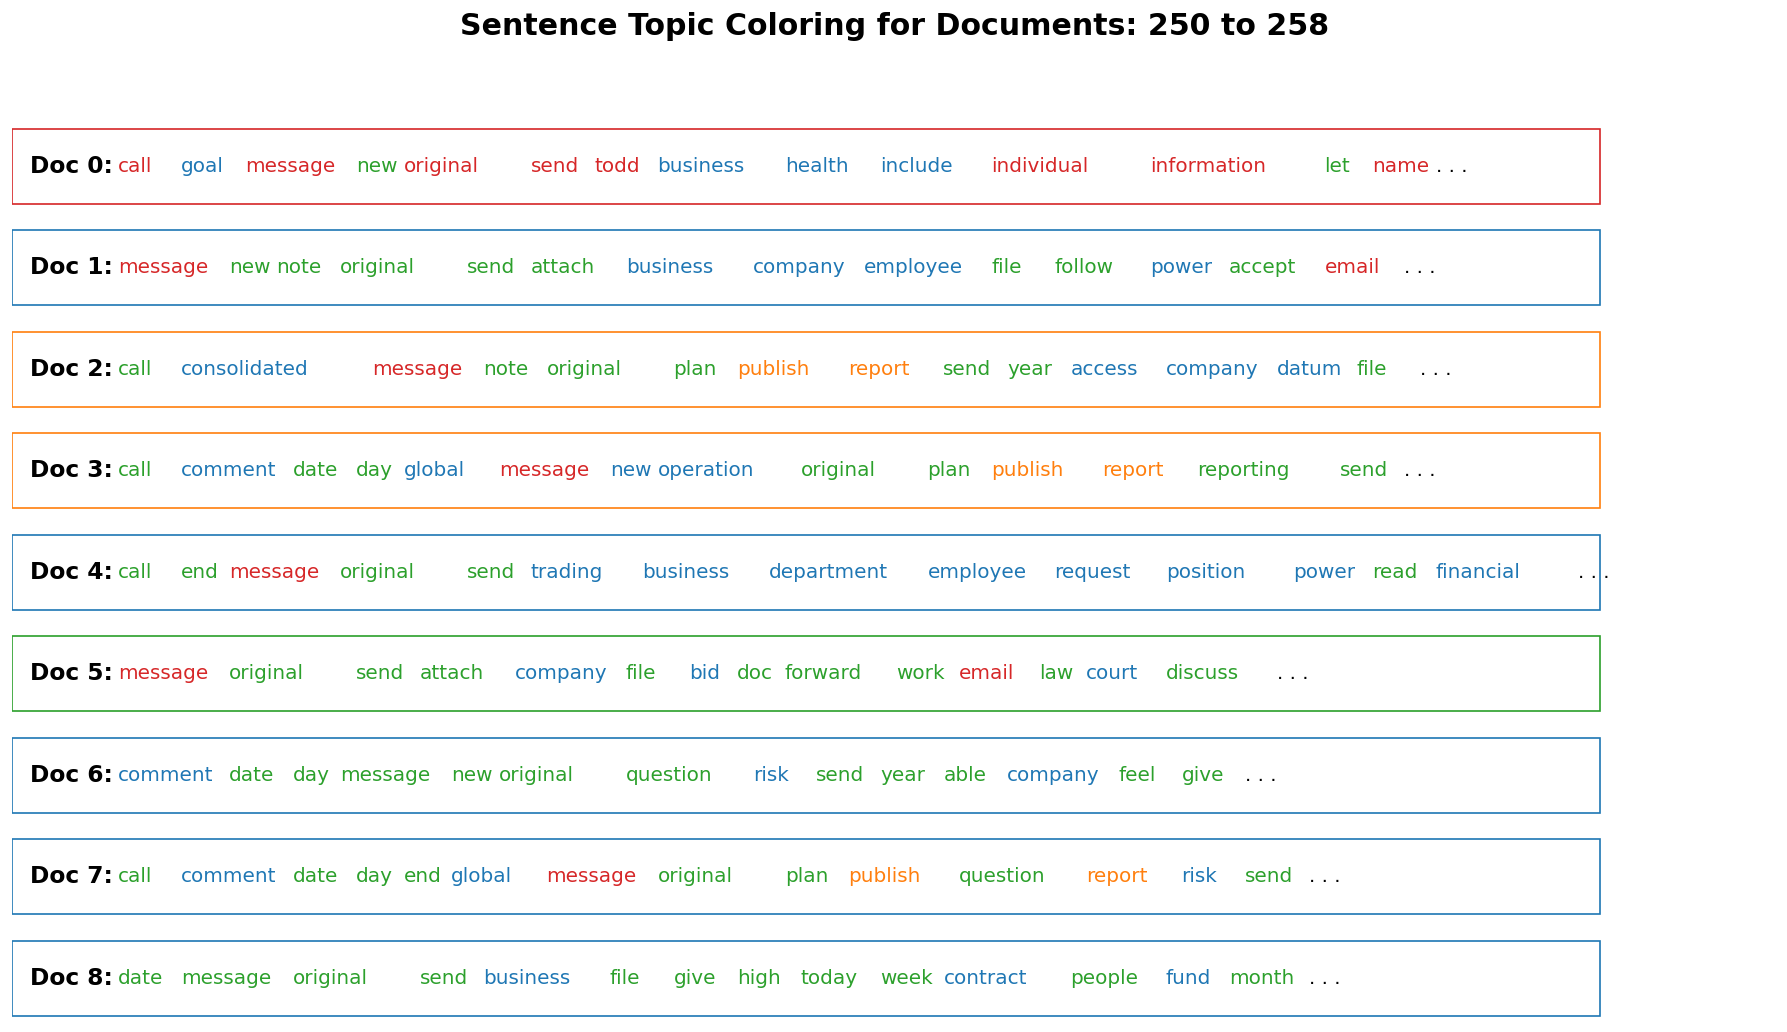

In [70]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 250, end = 260):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(15, (end-start)*0.90), dpi=120)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=14, color='black', transform=ax.transAxes, fontweight=700)

            
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.90, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=1))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=400)
                    word_pos += .009 * len(word)  
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=12, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=18, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# t-SNE Clustering 

In [71]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

   
arr = pd.DataFrame(topic_weights).fillna(0).values

arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=600, plot_height=500)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1700 samples in 0.004s...
[t-SNE] Computed neighbors for 1700 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1700
[t-SNE] Computed conditional probabilities for sample 1700 / 1700
[t-SNE] Mean sigma: 0.040643
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.293297
[t-SNE] KL divergence after 1000 iterations: 0.458637


Loading BokehJS ...